# AritmaPlay : Handwriting Recognizer Model

## Project Preparation

### Import Library

In [ ]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import zipfile,os,shutil
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files

### Install Kaggle

In [ ]:
!pip install kaggle --quiet

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


## Dataset

### Download Datasets

In [ ]:
!kaggle datasets download "pradheeprio/handwritten-digit-classification"
local_zip = '/content/handwritten-digit-classification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

!kaggle datasets download "clarencezhao/handwritten-math-symbol-dataset"
local_zip = '/content/handwritten-math-symbol-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

!kaggle datasets download "riyaldi/handwriting-digit-0-9"
local_zip = '/content/handwriting-digit-0-9.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Dataset URL: https://www.kaggle.com/datasets/pradheeprio/handwritten-digit-classification
License(s): copyright-authors
 53% 10.0M/19.0M [00:00<00:00, 23.7MB/s]
100% 19.0M/19.0M [00:00<00:00, 42.5MB/s]
Dataset URL: https://www.kaggle.com/datasets/clarencezhao/handwritten-math-symbol-dataset
License(s): copyright-authors
 85% 49.0M/57.8M [00:00<00:00, 77.3MB/s]
100% 57.8M/57.8M [00:00<00:00, 74.0MB/s]
Dataset URL: https://www.kaggle.com/datasets/riyaldi/handwriting-digit-0-9
License(s): apache-2.0
 89% 65.0M/73.2M [00:01<00:00, 42.4MB/s]
100% 73.2M/73.2M [00:02<00:00, 38.0MB/s]


### Delete unused class folder

In [ ]:
#delete a folder in eval folder
folder_to_delete_eval = ['decimal val', 'div val', 'equal val', 'minus val', 'number', 'plus val', 'sign', 'times val']
folder_to_delete_train = ['decimal' ,'div', 'equal', 'minus', 'original number', 'plus cleaned', 'times', 'original sign', 'other number', 'other sign']

for folder in folder_to_delete_eval:
  shutil.rmtree('/tmp/eval/' + folder)

for folder in folder_to_delete_train:
  shutil.rmtree('/tmp/train/' + folder)

### Merge Train & Validation folder

In [ ]:
train_dir = '/tmp/eval/'
val_dir = '/tmp/train/'
merged_dir = '/tmp/merged_folder'

if not os.path.exists(merged_dir):
    os.makedirs(merged_dir)

def merge_folders(source_dir, dest_dir):
    subfolders = os.listdir(source_dir)

    for subfolder in subfolders:
        source_subfolder = os.path.join(source_dir, subfolder)
        dest_subfolder = os.path.join(dest_dir, subfolder)

        if not os.path.exists(dest_subfolder):
            os.makedirs(dest_subfolder)

        for file in os.listdir(source_subfolder):
            source_file = os.path.join(source_subfolder, file)
            dest_file = os.path.join(dest_subfolder, file)

            if not os.path.exists(dest_file):
                shutil.copy2(source_file, dest_file)

print("Merging train folder...")
merge_folders(train_dir, merged_dir)

print("Merging val folder...")
merge_folders(val_dir, merged_dir)

print("Merging complete!")

for folder in os.listdir(merged_dir):
    folder_path = os.path.join(merged_dir, folder)
    file_count = len(os.listdir(folder_path))
    print(f"Folder '{folder}' contains {file_count} files")

shutil.rmtree('/tmp/eval')
shutil.rmtree('/tmp/train')

Merging train folder...
Merging val folder...
Merging complete!
Folder 'three' contains 483 files
Folder 'two' contains 484 files
Folder 'six' contains 482 files
Folder 'four' contains 484 files
Folder 'nine' contains 484 files
Folder 'five' contains 485 files
Folder 'zero' contains 478 files
Folder 'seven' contains 484 files
Folder 'one' contains 487 files
Folder 'eight' contains 483 files


### Change dataset class folder naming

In [ ]:
folder_mapping = {
    'one': '1',
    'two': '2',
    'three': '3',
    'four': '4',
    'five': '5',
    'six': '6',
    'seven': '7',
    'eight': '8',
    'nine': '9',
    'zero': '0',
}

merged_dir = '/tmp/merged_folder'

for old_name in list(os.listdir(merged_dir)):
    if old_name in folder_mapping:
        old_path = os.path.join(merged_dir, old_name)
        new_path = os.path.join(merged_dir, folder_mapping[old_name])

        try:
            os.rename(old_path, new_path)
            print(f"Renamed '{old_name}' to '{folder_mapping[old_name]}'")
        except Exception as e:
            print(f"Error renaming '{old_name}': {str(e)}")

print("\nRenaming complete!")

print("\nFinal folder structure:")
for folder in sorted(os.listdir(merged_dir)):
    folder_path = os.path.join(merged_dir, folder)
    file_count = len(os.listdir(folder_path))
    print(f"Folder '{folder}' contains {file_count} files")

Renamed 'three' to '3'
Renamed 'two' to '2'
Renamed 'six' to '6'
Renamed 'four' to '4'
Renamed 'nine' to '9'
Renamed 'five' to '5'
Renamed 'zero' to '0'
Renamed 'seven' to '7'
Renamed 'one' to '1'
Renamed 'eight' to '8'

Renaming complete!

Final folder structure:
Folder '0' contains 478 files
Folder '1' contains 487 files
Folder '2' contains 484 files
Folder '3' contains 483 files
Folder '4' contains 484 files
Folder '5' contains 485 files
Folder '6' contains 482 files
Folder '7' contains 484 files
Folder '8' contains 483 files
Folder '9' contains 484 files


Merge Datasets

In [ ]:
dataset1 = '/tmp/database/'
dataset2 = '/tmp/merged_folder/'
dataset3 = '/tmp/handDigitDataset/'
merged_dir = '/tmp/merged_datasets'

if not os.path.exists(merged_dir):
    os.makedirs(merged_dir)

def merge_folders(source_dir, dest_dir):
    subfolders = os.listdir(source_dir)

    for subfolder in subfolders:
        source_subfolder = os.path.join(source_dir, subfolder)
        dest_subfolder = os.path.join(dest_dir, subfolder)

        if not os.path.exists(dest_subfolder):
            os.makedirs(dest_subfolder)

        for file in os.listdir(source_subfolder):
            source_file = os.path.join(source_subfolder, file)
            dest_file = os.path.join(dest_subfolder, file)

            if not os.path.exists(dest_file):
                shutil.copy2(source_file, dest_file)

print("Merging dataset1 folder...")
merge_folders(dataset1, merged_dir)

print("Merging dataset2 folder...")
merge_folders(dataset2, merged_dir)

print("Merging dataset3 folder...")
merge_folders(dataset3, merged_dir)


print("Merging complete!")

for folder in os.listdir(merged_dir):
    folder_path = os.path.join(merged_dir, folder)
    file_count = len(os.listdir(folder_path))
    print(f"Folder '{folder}' contains {file_count} files")

shutil.rmtree(dataset1)
shutil.rmtree(dataset2)
shutil.rmtree(dataset3)

Merging dataset1 folder...
Merging dataset2 folder...
Merging dataset3 folder...
Merging complete!
Folder '7' contains 4906 files
Folder '8' contains 4872 files
Folder '3' contains 4886 files
Folder '6' contains 4871 files
Folder '1' contains 4900 files
Folder '2' contains 4865 files
Folder '4' contains 4891 files
Folder '5' contains 4881 files
Folder '9' contains 4891 files
Folder '0' contains 4877 files


### Split Dataset

In [ ]:
BATCH_SIZE = 32

train_set, temp_test = tf.keras.preprocessing.image_dataset_from_directory(
    "/tmp/merged_datasets",
    label_mode="categorical",
    color_mode="grayscale",
    image_size=(48, 48),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="both",
    verbose=False
)

class_names = train_set.class_names

val_test_split = 0.5

total_batches = int(tf.data.experimental.cardinality(temp_test))
val_batches = total_batches // 2

val_set = temp_test.take(val_batches)
test_set = temp_test.skip(val_batches)

AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)


train_batches = tf.data.experimental.cardinality(train_set).numpy()
val_batches = tf.data.experimental.cardinality(val_set).numpy()
test_batches = tf.data.experimental.cardinality(test_set).numpy()

print("\nDataset Information:")
print(f"Training:   {train_batches} batches, {train_batches * BATCH_SIZE} images")
print(f"Validation: {val_batches} batches, {val_batches * BATCH_SIZE} images")
print(f"Testing:    {test_batches} batches, {test_batches * BATCH_SIZE} images")
print(f"Total:      {train_batches + val_batches + test_batches} batches, "
      f"{(train_batches + val_batches + test_batches) * BATCH_SIZE} images")

Using 39072 files for training.
Using 9768 files for validation.

Dataset Information:
Training:   1221 batches, 39072 images
Validation: 153 batches, 4896 images
Testing:    153 batches, 4896 images
Total:      1527 batches, 48864 images


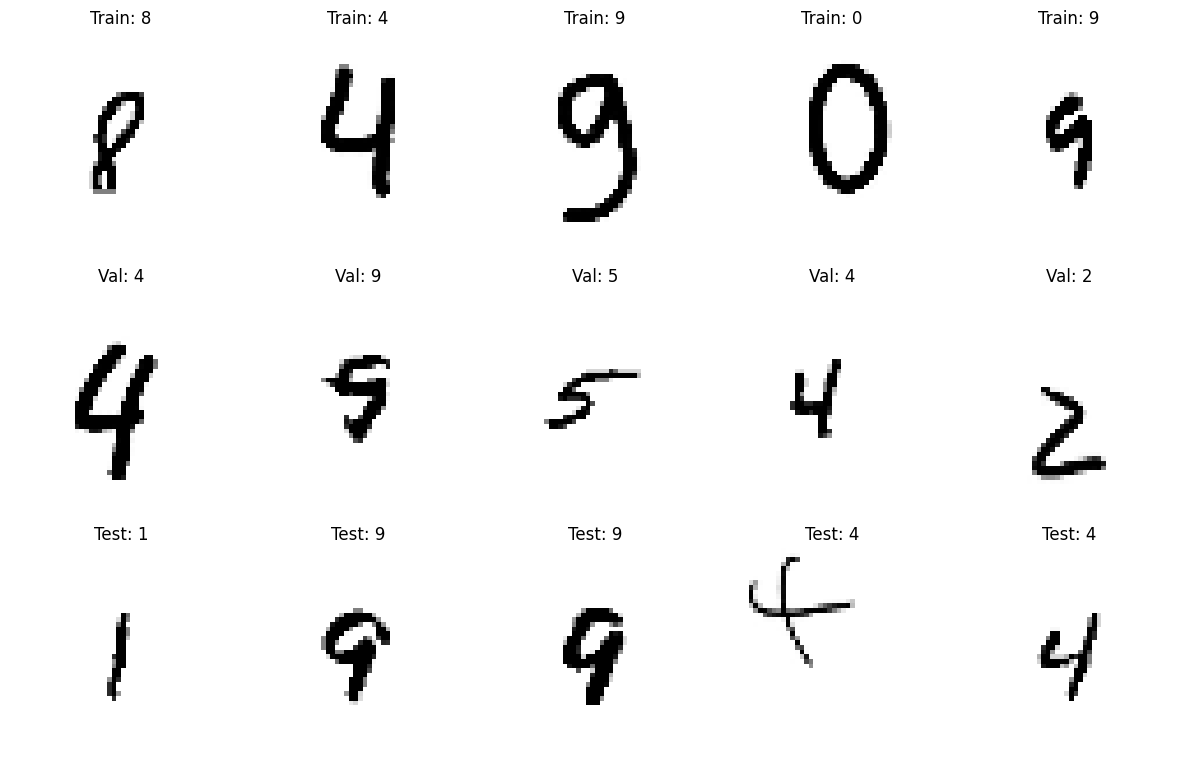

In [ ]:
plt.figure(figsize=(12, 8))

# Training samples
for i in range(5):
    plt.subplot(3, 5, i+1)
    for images, labels in train_set.take(1):
        plt.imshow(tf.squeeze(images[i]).numpy(), cmap='gray')
        predicted_class_index = tf.argmax(labels[i]).numpy()
        plt.title(f'Train: {class_names[predicted_class_index]}')
        plt.axis("off")

# Validation samples
for i in range(5):
    plt.subplot(3, 5, i+6)
    for images, labels in val_set.take(1):
        plt.imshow(tf.squeeze(images[i]).numpy(), cmap='gray')
        predicted_class_index = tf.argmax(labels[i]).numpy()
        plt.title(f'Val: {class_names[predicted_class_index]}')
        plt.axis("off")

# Test samples
for i in range(5):
    plt.subplot(3, 5, i+11)
    for images, labels in test_set.take(1):
        plt.imshow(tf.squeeze(images[i]).numpy(), cmap='gray')
        predicted_class_index = tf.argmax(labels[i]).numpy()
        plt.title(f'Test: {class_names[predicted_class_index]}')
        plt.axis("off")

plt.tight_layout()
plt.show()

## Models

### Model 1

In [ ]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Input((48, 48, 1)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          16,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,954 (81.85 KB)

 Trainable params: 20,954 (81.85 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='loss', mode='min', patience=3,  restore_best_weights=True)

history1 = model1.fit(
                  train_set,
                  epochs=20,
                  validation_data=val_set,
                  callbacks=[es])

Epoch 1/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.5612 - loss: 1.3568 - val_accuracy: 0.8125 - val_loss: 0.5008
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1221/1221 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8521 - loss: 0.5384 - val_accuracy: 0.8750 - val_loss: 0.4030
Epoch 3/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8819 - loss: 0.4299 - val_accuracy: 0.8750 - val_loss: 0.4364
Epoch 4/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8990 - loss: 0.3621 - val_accuracy: 0.9375 - val_loss: 0.2455
Epoch 5/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9152 - loss: 0.3030 - val_accuracy: 0.8438 - val_loss: 0.5298
Epoch 6/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9241 - loss: 0.2720 - val_accuracy: 0.9375 - val_loss: 0.3945
Epoch 7/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9274 - loss: 0.2485 - val_accuracy: 0.9062 - val_loss: 0.3549
Epoch 8/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9370 - loss: 0.2202 - val_accuracy: 0.9062 - val_loss: 0.4140
Epoch 9/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9432 - loss: 0.2000 - val_acc

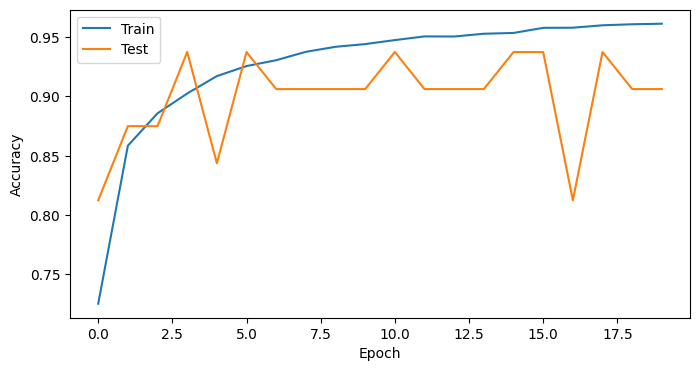

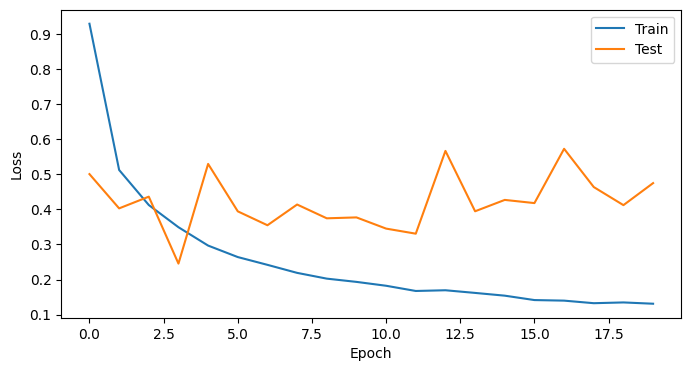

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train', 'Test'])

plt.figure(figsize=(8,4))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])

plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train', 'Test'])

###Model 2

In [ ]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Input((48, 48, 1)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 21, 21, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          16,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,954 (81.85 KB)

 Trainable params: 20,954 (81.85 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='loss', mode='min', patience=3,  restore_best_weights=True)

history2 = model2.fit(
                  train_set,
                  epochs=20,
                  validation_data=val_set,
                  callbacks=[es])

Epoch 1/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6319 - loss: 1.1531 - val_accuracy: 0.8750 - val_loss: 0.3977
Epoch 2/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9056 - loss: 0.3453 - val_accuracy: 0.9062 - val_loss: 0.2452
Epoch 3/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9273 - loss: 0.2550 - val_accuracy: 0.9062 - val_loss: 0.3071
Epoch 4/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9355 - loss: 0.2214 - val_accuracy: 0.9688 - val_loss: 0.2084
Epoch 5/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9464 - loss: 0.1787 - val_accuracy: 0.9688 - val_loss: 0.1592
Epoch 6/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9550 - loss: 0.1568 - val_accuracy: 0.9688 - val_loss: 0.1249
Epoch 7/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9603 - loss: 0.1353 - val_accuracy: 0.9688 - val_loss: 0.1554
Epoch 8/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9633 - loss: 0.1264 - 

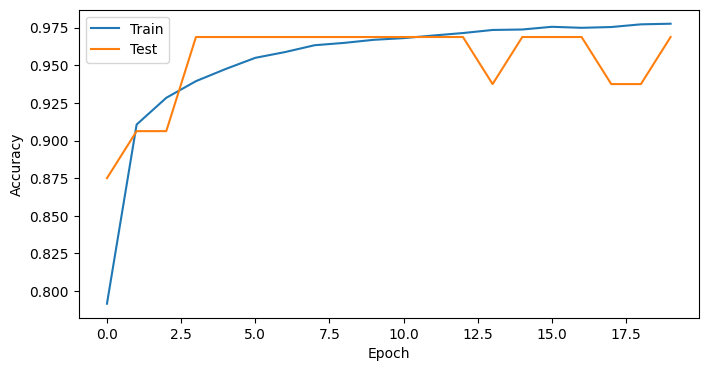

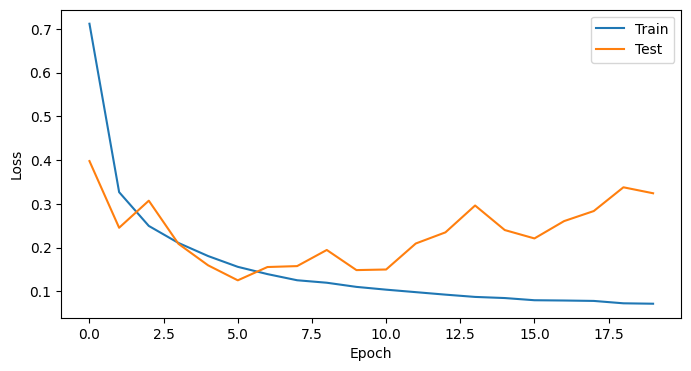

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train', 'Test'])

plt.figure(figsize=(8,4))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train', 'Test'])

###Model 3

In [ ]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Input((48, 48, 1)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='softmax')
])

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 21, 21, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 10, 10, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          16,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,954 (81.85 KB)

 Trainable params: 20,954 (81.85 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='loss', mode='min', patience=3,  restore_best_weights=True)

history3 = model3.fit(
                  train_set,
                  epochs=20,
                  validation_data=val_set,
                  callbacks=[es])

Epoch 1/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6546 - loss: 1.1016 - val_accuracy: 0.8438 - val_loss: 0.3795
Epoch 2/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9198 - loss: 0.2887 - val_accuracy: 0.8750 - val_loss: 0.3047
Epoch 3/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9446 - loss: 0.1962 - val_accuracy: 0.8750 - val_loss: 0.2328
Epoch 4/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9562 - loss: 0.1486 - val_accuracy: 0.9062 - val_loss: 0.1483
Epoch 5/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9646 - loss: 0.1219 - val_accuracy: 0.9375 - val_loss: 0.1720
Epoch 6/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9714 - loss: 0.0977 - val_accuracy: 0.9062 - val_loss: 0.2277
Epoch 7/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9742 - loss: 0.0894 - val_accuracy: 0.9375 - val_loss: 0.1732
Epoch 8/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9784 - loss: 0.0721 - 

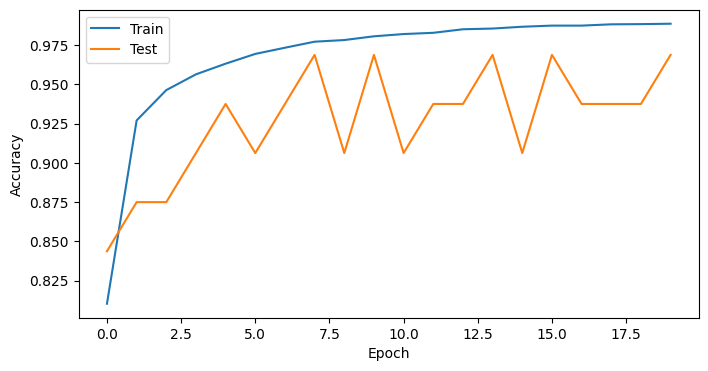

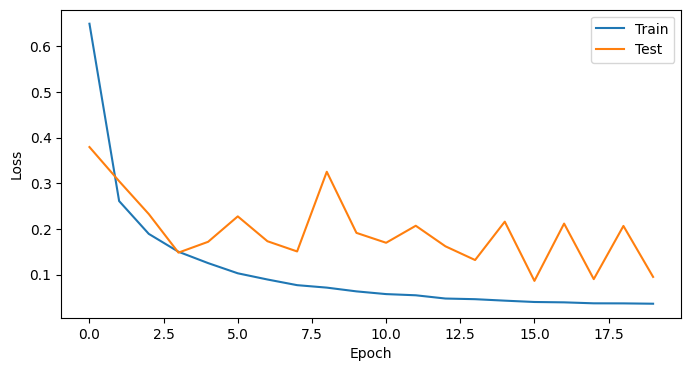

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train', 'Test'])

plt.figure(figsize=(8,4))
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])

plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train', 'Test'])

## Model Evaluation


### Compare Model


Model 1 Evaluation:
Test Loss: 0.1788
Test Accuracy: 0.9538

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       508
           1       0.98      0.98      0.98       493
           2       0.93      0.98      0.95       520
           3       0.96      0.97      0.96       491
           4       0.89      0.98      0.93       486
           5       0.91      0.98      0.94       473
           6       0.95      0.96      0.96       475
           7       0.99      0.94      0.97       496
           8       0.96      0.93      0.95       457
           9       0.97      0.88      0.92       473

    accuracy                           0.95      4872
   macro avg       0.96      0.95      0.95      4872
weighted avg       0.96      0.95      0.95      4872


Model 2 Evaluation:
Test Loss: 0.0812
Test Accuracy: 0.9789

Classification Report:
              precision    recall  f1-score   support

           0    

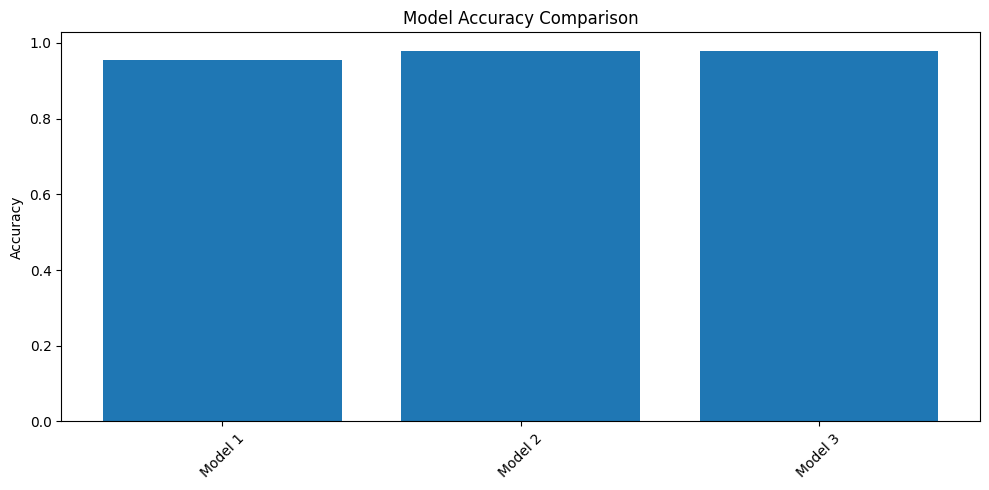

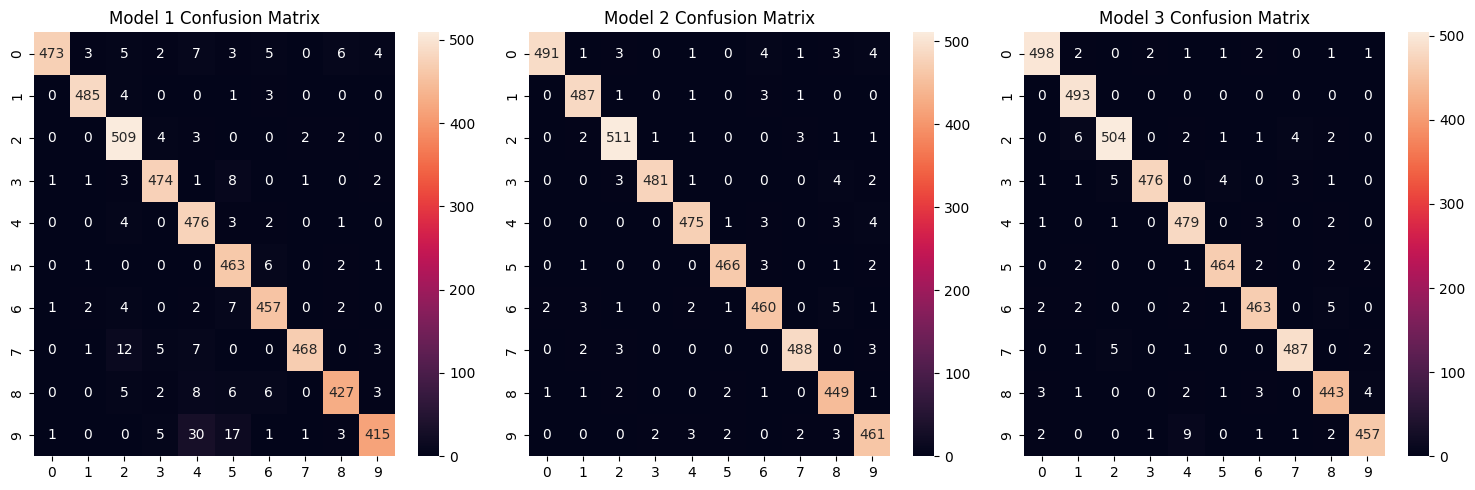


Model 1 Accuracy: 0.9538

Model 2 Accuracy: 0.9789

Model 3 Accuracy: 0.9778


In [ ]:
def compare_multiple_models(models, test_set, class_names):
    results = {}

    for model, model_name in models:
        print(f"\n{model_name} Evaluation:")

        loss, accuracy = model.evaluate(test_set, verbose=0)

        y_pred = model.predict(test_set, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)

        y_true = np.concatenate([y for x, y in test_set], axis=0)
        y_true_classes = np.argmax(y_true, axis=1)

        results[model_name] = {
            'loss': loss,
            'accuracy': accuracy,
            'predictions': y_pred_classes,
            'confusion_matrix': confusion_matrix(y_true_classes, y_pred_classes),
            'classification_report': classification_report(y_true_classes, y_pred_classes)
        }

        print(f"Test Loss: {loss:.4f}")
        print(f"Test Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(results[model_name]['classification_report'])

    # Accuracy Comparison
    plt.figure(figsize=(10, 5))
    accuracies = [results[model_name]['accuracy'] for model_name in results.keys()]
    plt.bar(results.keys(), accuracies)
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Confusion Matrices
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 5))

    for idx, model_name in enumerate(results.keys()):
        sns.heatmap(results[model_name]['confusion_matrix'],
                   annot=True,
                   fmt='d',
                   ax=axes[idx] if n_models > 1 else axes)
        axes[idx].set_title(f'{model_name} Confusion Matrix') if n_models > 1 else axes.set_title(f'{model_name} Confusion Matrix')

    plt.tight_layout()
    plt.show()

    return results

models_to_compare = [
    (model1, "Model 1"),
    (model2, "Model 2"),
    (model3, "Model 3"),
]

results = compare_multiple_models(models_to_compare, test_set, class_names)

for model_name in results:
    print(f"\n{model_name} Accuracy: {results[model_name]['accuracy']:.4f}")

## Deployment

In [ ]:
FINAL_MODEL = model2

### Export to H5


In [ ]:
FINAL_MODEL.save("model.h5")

### Save model to GCS

In [ ]:
from google.colab import auth
# auth.authenticate_user()

project_id = 'capstone-c242-ps102'
!gcloud config set project {project_id}

bucket_name = 'capstone-c242-ps102_model'

!gsutil mb gs://{bucket_name}

!gsutil cp /content/model.h5 gs://{bucket_name}/

# !gsutil cat gs://{bucket_name}/model.h5

Are you sure you wish to set property [core/project] to capstone-c242-ps102?

Do you want to continue (Y/n)?  y

Updated property [core/project].
Creating gs://capstone-c242-ps102_model/...
You are attempting to access protected data with no configured
credentials. Please visit https://cloud.google.com/console#/project
and sign up for an account, and then run the "gcloud auth login"
command to configure gsutil to use these credentials.
Copying file:///content/model.h5 [Content-Type=application/x-hdf5]...
- [1 files][281.6 KiB/281.6 KiB]                                                
Operation completed over 1 objects/281.6 KiB.                                    
